<h1>Implementación de algoritmo para obtener los sentimientos en conversaciones con chatbots</h1>


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np   

In [2]:
import pymongo

from pymongo import MongoClient

client = MongoClient("localhost", 27017)

db = client['chatbot_analysis']

In [3]:
collection = db['conversations']

# Query the collection
result = collection.find()

In [4]:
from pandas import DataFrame

list_cur = list(result)

df = DataFrame(list_cur)

df.head()

,_id,id,timestamp,conversation
0,64a8f46750e51f4f98981c2f,1,2023-01-01T00:10:35Z,{'user': 'Thank you for your help! I'm really ...
1,64a8f46750e51f4f98981c30,2,2023-01-02T09:23:18Z,{'user': 'I'm impressed with the quick respons...
2,64a8f46750e51f4f98981c31,3,2023-01-03T17:45:52Z,{'user': 'Your customer service is excellent. ...
3,64a8f46750e51f4f98981c32,4,2023-01-05T08:02:10Z,{'user': 'I've had a great experience shopping...
4,64a8f46750e51f4f98981c33,5,2023-01-08T14:30:21Z,{'user': 'Your support team was very helpful. ...


In [5]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the required NLTK resources
nltk.download('vader_lexicon')

# Create an instance of the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to calculate sentiment scores (1->Positive, 0 neutral, -1 negative)
def get_sentiment_score(text):
    sentiment_scores = sia.polarity_scores(str(text))
    if sentiment_scores['compound'] >= 0.05:
        score = 1
 
    elif sentiment_scores['compound'] <= - 0.05:
        score = -1
 
    else:
        score = 0
    return score

# Apply sentiment analysis and save the sentiment score as a new column
df['sentiment_score'] = df['conversation'].apply(get_sentiment_score)

df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\karla\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,_id,id,timestamp,conversation,sentiment_score
0,64a8f46750e51f4f98981c2f,1,2023-01-01T00:10:35Z,{'user': 'Thank you for your help! I'm really ...,1
1,64a8f46750e51f4f98981c30,2,2023-01-02T09:23:18Z,{'user': 'I'm impressed with the quick respons...,1
2,64a8f46750e51f4f98981c31,3,2023-01-03T17:45:52Z,{'user': 'Your customer service is excellent. ...,1
3,64a8f46750e51f4f98981c32,4,2023-01-05T08:02:10Z,{'user': 'I've had a great experience shopping...,1
4,64a8f46750e51f4f98981c33,5,2023-01-08T14:30:21Z,{'user': 'Your support team was very helpful. ...,1
...,...,...,...,...,...
218,64d749684329191049f870eb,1000,2023-08-12 08:57:12.674000,"{'user': 'please some song suggestions', 'chat...",1
219,64d749ff43f073ac3859052b,1000,2023-08-12 08:59:43.639000,"{'user': 'pls some song suggestions', 'chatbot...",1
220,64db17ac0979564a18c7a9d6,1000,2023-08-15 06:14:04.743000,{'user': 'please act as a chatbot of a departa...,1
221,64db17f50979564a18c7a9d8,1000,2023-08-15 06:15:17.880000,"{'user': 'hello, I am experimenting some issue...",1


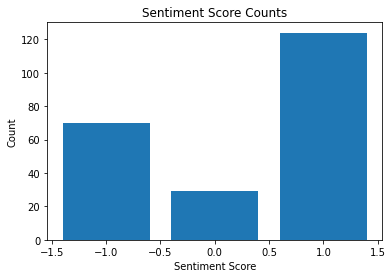

In [6]:
# Count the occurrences of each attribute
attribute_counts = df['sentiment_score'].value_counts()

# Create a bar plot to visualize the counts
plt.bar(attribute_counts.index, attribute_counts.values)

# Set the plot title and axis labels
plt.title('Sentiment Score Counts')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')

# Display the plot
plt.show()


In [7]:
import statsmodels.api as sm

df['timestamp'] = pd.to_datetime(df['timestamp'],utc=True)
#df['timestamp'].dt.hour
# Extract the hour from the datetime
df['hour'] = df['timestamp'].dt.hour

# Perform linear regression
X = df['hour']
y = df['sentiment_score']
X = sm.add_constant(X)  # Add a constant term
model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        sentiment_score   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.644
Date:                Tue, 15 Aug 2023   Prob (F-statistic):             0.0576
Time:                        00:31:55   Log-Likelihood:                -291.29
No. Observations:                 223   AIC:                             586.6
Df Residuals:                     221   BIC:                             593.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6455      0.220      2.938      0.004       0.213       1.079
hour          -0.0315      0.017     -1.909      0.058      -0.064       0.001
==============================================================================
Omnibus:                     2484.753   Durbin-Watson:                   1.568
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.290
Skew:                          -0.454   Prob(JB):                     2.65e-07
Kurtosis:                       1.439   Cond. No.                         48.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

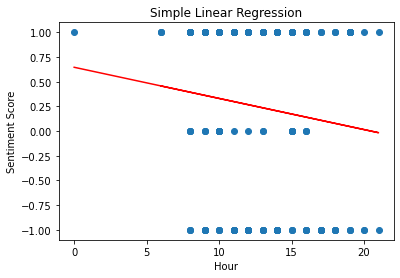

In [8]:
plt.scatter(df['hour'], df['sentiment_score'])
plt.plot(df['hour'], results.predict(X), color='red')
plt.xlabel('Hour')
plt.ylabel('Sentiment Score')
plt.title('Simple Linear Regression')
plt.show()

In [9]:
df

,_id,id,timestamp,conversation,sentiment_score,hour
0,64a8f46750e51f4f98981c2f,1,2023-01-01 00:10:35+00:00,{'user': 'Thank you for your help! I'm really ...,1,0
1,64a8f46750e51f4f98981c30,2,2023-01-02 09:23:18+00:00,{'user': 'I'm impressed with the quick respons...,1,9
2,64a8f46750e51f4f98981c31,3,2023-01-03 17:45:52+00:00,{'user': 'Your customer service is excellent. ...,1,17
3,64a8f46750e51f4f98981c32,4,2023-01-05 08:02:10+00:00,{'user': 'I've had a great experience shopping...,1,8
4,64a8f46750e51f4f98981c33,5,2023-01-08 14:30:21+00:00,{'user': 'Your support team was very helpful. ...,1,14
...,...,...,...,...,...,...
218,64d749684329191049f870eb,1000,2023-08-12 08:57:12.674000+00:00,"{'user': 'please some song suggestions', 'chat...",1,8
219,64d749ff43f073ac3859052b,1000,2023-08-12 08:59:43.639000+00:00,"{'user': 'pls some song suggestions', 'chatbot...",1,8
220,64db17ac0979564a18c7a9d6,1000,2023-08-15 06:14:04.743000+00:00,{'user': 'please act as a chatbot of a departa...,1,6
221,64db17f50979564a18c7a9d8,1000,2023-08-15 06:15:17.880000+00:00,"{'user': 'hello, I am experimenting some issue...",1,6


In [10]:
# For regular expressions
import re
# For handling string
import string

contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have","user":"","chatbot":""}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['conversation_expand']=df['conversation'].apply(lambda x:expand_contractions(str(x)))

In [11]:
df['conv_cleaned']=df['conversation_expand'].apply(lambda x: x.lower())
df['conv_cleaned']=df['conv_cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [12]:
df['conv_cleaned']=df['conv_cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df['conv_cleaned']=df['conv_cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df['conv_cleaned']=df['conv_cleaned'].apply(lambda x: re.sub(' +',' ',x))
df

,_id,id,timestamp,conversation,sentiment_score,hour,conversation_expand,conv_cleaned
0,64a8f46750e51f4f98981c2f,1,2023-01-01 00:10:35+00:00,{'user': 'Thank you for your help! I'm really ...,1,0,"{'': ""Thank you for your help! I am really sat...",thank you for your help i am really satisfied...
1,64a8f46750e51f4f98981c30,2,2023-01-02 09:23:18+00:00,{'user': 'I'm impressed with the quick respons...,1,9,"{'': ""I am impressed with the quick response t...",i am impressed with the quick response time g...
2,64a8f46750e51f4f98981c31,3,2023-01-03 17:45:52+00:00,{'user': 'Your customer service is excellent. ...,1,17,"{'': ""Your customer service is excellent. I am...",your customer service is excellent i am reall...
3,64a8f46750e51f4f98981c32,4,2023-01-05 08:02:10+00:00,{'user': 'I've had a great experience shopping...,1,8,"{'': ""I have had a great experience shopping o...",i have had a great experience shopping on you...
4,64a8f46750e51f4f98981c33,5,2023-01-08 14:30:21+00:00,{'user': 'Your support team was very helpful. ...,1,14,"{'': ""Your support team was very helpful. I am...",your support team was very helpful i am satis...
...,...,...,...,...,...,...,...,...
218,64d749684329191049f870eb,1000,2023-08-12 08:57:12.674000+00:00,"{'user': 'please some song suggestions', 'chat...",1,8,"{'': 'please some song suggestions', '': [{'in...",please some song suggestions index message ro...
219,64d749ff43f073ac3859052b,1000,2023-08-12 08:59:43.639000+00:00,"{'user': 'pls some song suggestions', 'chatbot...",1,8,"{'': 'pls some song suggestions', '': 'Sure! H...",pls some song suggestions sure here are some ...
220,64db17ac0979564a18c7a9d6,1000,2023-08-15 06:14:04.743000+00:00,{'user': 'please act as a chatbot of a departa...,1,6,{'': 'please act as a of a departamental stor...,please act as a of a departamental store solv...
221,64db17f50979564a18c7a9d8,1000,2023-08-15 06:15:17.880000+00:00,"{'user': 'hello, I am experimenting some issue...",1,6,"{'': 'hello, I am experimenting some issues wi...",hello i am experimenting some issues with you...


In [13]:
import spacy

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['lemmatized']=df['conv_cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [14]:
df_grouped=df[['id','lemmatized']].groupby(by='id').agg(lambda x:' '.join(x))
df_grouped.head()

,lemmatized
id,
1,thank help satisfied service welcome glad he...
2,impressed quick response time great job than...
3,customer service excellent happy assistance ...
4,great experience shop website thrilled hear ...
5,support team helpful satisfied resolution pr...


In [15]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(analyzer='word')
data=cv.fit_transform(df_grouped['lemmatized'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df_grouped.index
df_dtm.head(3)

,abc,able,absolute,absolutely,accept,accordingly,account,accurate,accusation,act,...,word,work,worried,wow,wrong,xyz,yeah,yes,zeppelin,zip
id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


AttributeError: 'int' object has no attribute 'expandtabs'

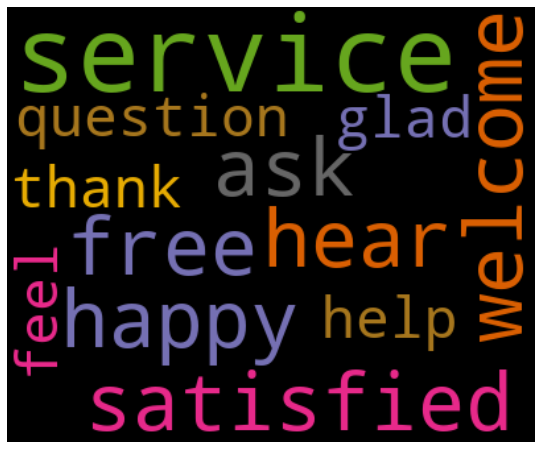

In [16]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()
  
# Transposing document term matrix
df_dtm=df_dtm.transpose()

# Plotting word cloud for each product
for index,product in enumerate(df_dtm.columns):
  generate_wordcloud(df_dtm[product].sort_values(ascending=False),product)

In [17]:
df_dtm

id,1,2,3,4,5,6,7,8,9,10,...,212,213,214,215,216,217,218,219,220,1000
abc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
able,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
absolute,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
absolutely,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
accept,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xyz,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
yeah,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
yes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zeppelin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
def plot_top_10_occurrences(series, numeric_column):
    # Step 1: Sort the Series by the numeric column in descending order
    sorted_series = series.sort_values(ascending=False)

    # Step 2: Select the first ten values from the sorted Series
    top_10_values = sorted_series.head(10)

    # Step 3: Create a bar plot to visualize the counts
    plt.bar(top_10_values.index, top_10_values)
    plt.xlabel('Values')
    plt.ylabel('Counts')
    plt.title(f'Top 10 Occurrences of {numeric_column}')
    plt.xticks(rotation=45)
    plt.show()

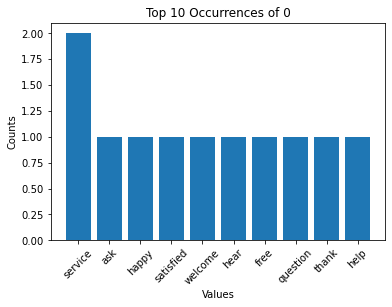

In [19]:
plot_top_10_occurrences(df_dtm[product], 0)

In [ ]:
df


In [20]:
import spacy

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

def analyze_sentiment(text):
    doc = nlp(text)
    sentiment_score = sum([token.sentiment.polarity for token in doc])
    if sentiment_score > 0:
        return 1
    elif sentiment_score < 0:
        return -1
    else:
        return 0



df['sentiment_score2'] = df['conv_cleaned'].apply(get_sentiment_score)

In [ ]:
df

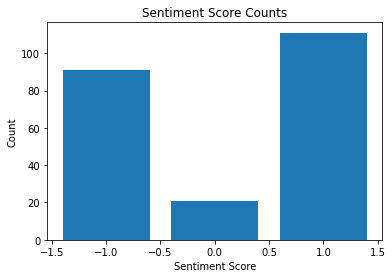

In [21]:
# Count the occurrences of each attribute
attribute_counts = df['sentiment_score2'].value_counts()

# Create a bar plot to visualize the counts
plt.bar(attribute_counts.index, attribute_counts.values)

# Set the plot title and axis labels
plt.title('Sentiment Score Counts')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')

# Display the plot
plt.show()